<a href="https://colab.research.google.com/github/earltreloar/logosfield-cddr-analysis/blob/main/Mechanism1_SpinAlignment_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanism 1 — Spin Alignment (Colab)

In [1]:
#@title 0. Setup
!pip -q install numpy pandas matplotlib scipy
import numpy as np, pandas as pd, matplotlib.pyplot as plt
print("Ready.")

Ready.


In [2]:
#@title 1. (Optional) Mount Drive
USE_DRIVE = False  #@param {type:"boolean"}
real_path = ""     #@param {type:"string"}
if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
#@title 2. Load data (stub or Drive CSV)
if USE_DRIVE and real_path:
    df = pd.read_csv(real_path)
    assert {'ra','dec','spin_sign'}.issubset(df.columns), "CSV must have ra, dec, spin_sign"
else:
    rng = np.random.default_rng(42); N=600
    ra=rng.uniform(0,360,N); dec=rng.uniform(-60,60,N)
    phi_g=np.radians((5*ra+0.3*dec)%360)
    aligned=rng.random(N)<0.62
    phi_s = np.where(aligned, phi_g+rng.normal(0,0.35,N), phi_g+np.pi/2+rng.normal(0,0.35,N))
    spin_sign = np.sign(np.cos(phi_s-phi_g)).astype(int)
    df = pd.DataFrame(dict(ra=ra, dec=dec, spin_sign=spin_sign))
df.head()

,ra,dec,spin_sign
0,278.624177,-2.699295,1
1,157.996238,31.371908,1
2,309.095251,48.399345,-1
3,251.052490,26.483514,-1
4,33.903845,55.585347,1


In [4]:
#@title 3. Metric + permutation p-value
def alignment_fraction(spin_sign): return (np.array(spin_sign)>0).mean()
obs = alignment_fraction(df['spin_sign'])
rng=np.random.default_rng(7); reps=2000
vals=[alignment_fraction(rng.permutation(df['spin_sign'])) for _ in range(reps)]
p = (np.sum(np.array(vals)>=obs)+1)/(reps+1)
print(f"Observed={obs:.3f}, p≈{p:.3e}")

Observed=0.803, p≈1.000e+00


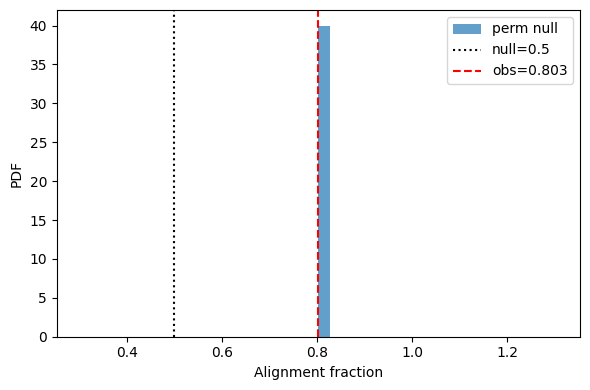

Wrote: /content/outputs_m1/summary.csv


In [5]:
#@title 4. Plot + save
plt.figure(figsize=(6,4))
plt.hist(vals, bins=40, density=True, alpha=0.7, label='perm null')
plt.axvline(0.5, color='k', ls=':', label='null=0.5')
plt.axvline(obs, color='r', ls='--', label=f'obs={obs:.3f}')
plt.legend(); plt.xlabel('Alignment fraction'); plt.ylabel('PDF'); plt.tight_layout(); plt.show()
out='/content/outputs_m1'; import os; os.makedirs(out, exist_ok=True)
pd.DataFrame({'obs':[obs],'p':[p]}).to_csv(f"{out}/summary.csv", index=False)
print("Wrote:", f"{out}/summary.csv")